In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
from tqdm import tqdm
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization, Activation, Input
from keras.models import Sequential, Model
from sklearn.metrics import confusion_matrix, classification_report
from keras import regularizers
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

warnings.filterwarnings("ignore")

2023-06-11 16:30:52.608692: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-11 16:30:52.998593: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-11 16:30:53.003674: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 16:30:56.109926: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
res = 216

def load_data(directory):
    images = []
    labels = []
    for folder in tqdm(os.listdir(directory)):
        label = folder
        data_path = os.path.join(directory, folder)
        if not os.path.isdir(data_path):
            continue
        for filename in tqdm(os.listdir(data_path), position=0, leave=True, desc=f"Loading images from {directory.split(os.sep)[-2]} folder"):
            img = cv2.imread(os.path.join(data_path, filename))
            if img is None:
                continue
            img = cv2.resize(img, (res, res))
            img = np.array(img)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)


In [3]:
x_train, y_train = load_data('chest_xray/chest_xray/train/')
x_test, y_test = load_data('chest_xray/chest_xray/test/')

100%|██████████| 3/3 [00:07<00:00,  2.42s/it]


In [4]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, shuffle = True, stratify = y_train)

In [5]:
x_train.shape, y_train.shape

((4172, 216, 216, 3), (4172,))

In [6]:
x_test.shape, y_test.shape

((624, 216, 216, 3), (624,))

In [7]:
def visualize_data(data, labels):
    normal_indices = np.where(labels == 'NORMAL')[0][:5]
    pneumonia_indices = np.where(labels == 'PNEUMONIA')[0][:5]
    fig, axs = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle('Examples of Pneumonia and Normal Images')
    for i, idx in enumerate(normal_indices):
        ax = axs[0, i]
        ax.imshow(data[idx])
        ax.set_title('Normal')
        ax.axis('off')

    for i, idx in enumerate(pneumonia_indices):
        ax = axs[1, i]
        ax.imshow(data[idx])
        ax.set_title('Pneumonia')
        ax.axis('off')

    plt.tight_layout()

    plt.show()

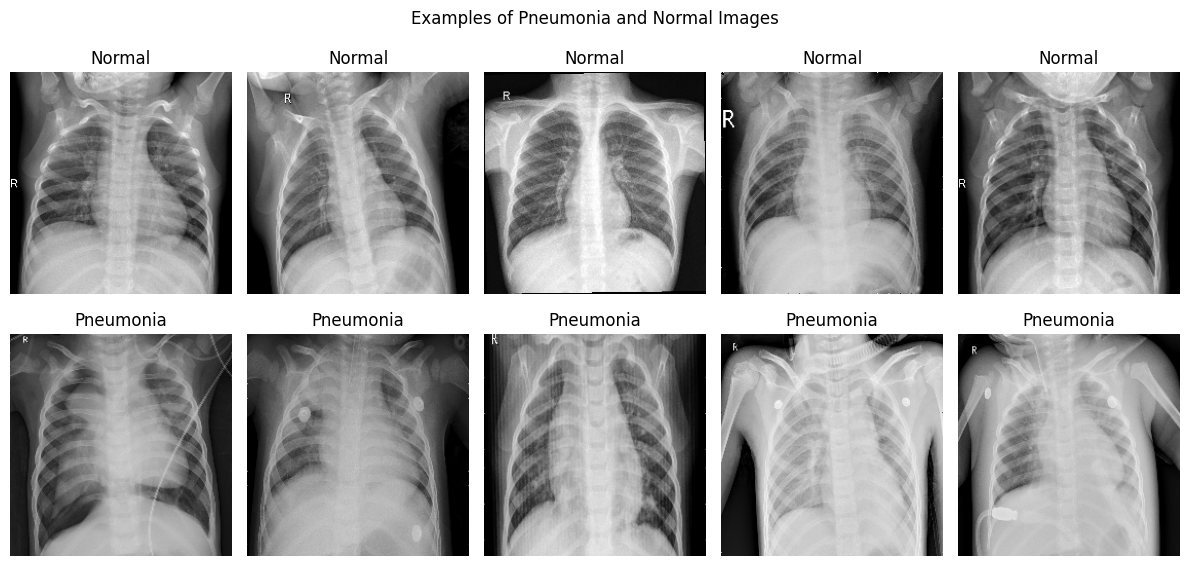

In [8]:
visualize_data(x_train, y_train)


In [9]:
train_counts = np.unique(y_train, return_counts=True)
test_counts = np.unique(y_test, return_counts=True)
val_counts = np.unique(y_val, return_counts=True)
print(train_counts)
print(test_counts)
print(val_counts)

print(x_train[0 : 623].shape, x_test.shape, x_val.shape)

(array(['NORMAL', 'PNEUMONIA'], dtype='<U9'), array([1073, 3099]))
(array(['NORMAL', 'PNEUMONIA'], dtype='<U9'), array([234, 390]))
(array(['NORMAL', 'PNEUMONIA'], dtype='<U9'), array([268, 776]))
(623, 216, 216, 3) (624, 216, 216, 3) (1044, 216, 216, 3)


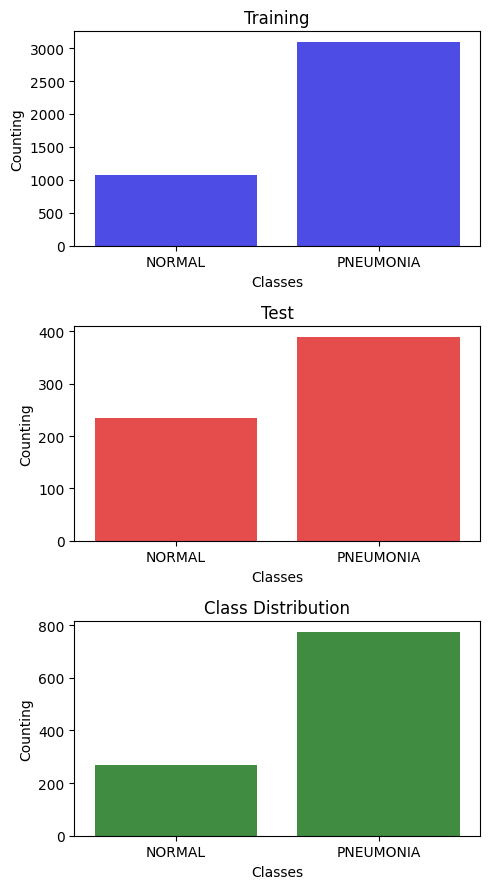

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(5, 9))
sns.barplot(ax = axs[0], x=train_counts[0], y=train_counts[1], color='blue', alpha=0.8, label='Training')
axs[0].set_xlabel('Classes')
axs[0].set_ylabel('Counting')
axs[0].set_title('Training')
sns.barplot(ax = axs[1], x=test_counts[0], y=test_counts[1], color='red', alpha=0.8, label='Testing')
axs[1].set_xlabel('Classes')
axs[1].set_ylabel('Counting')
axs[1].set_title('Test')
sns.barplot(ax = axs[2], x=val_counts[0], y=val_counts[1], color='green', alpha=0.8, label='Validating')
axs[2].set_xlabel('Classes')
axs[2].set_ylabel('Counting')
axs[2].set_title('Validatin')
plt.title('Class Distribution')
plt.tight_layout()
plt.show()

In [11]:
def build_cnn():
    l1l2 = regularizers.L1L2(l1=1e-4, l2=1e-3)
    classifier = Sequential()
    classifier.add(Conv2D(64, (3, 3), input_shape = (res, res, 3), activation = 'relu', kernel_regularizer = l1l2, padding = 'valid'))
    classifier.add(MaxPooling2D((2, 2)))
    classifier.add(BatchNormalization())
    
    classifier.add(Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer = l1l2, padding = 'valid'))
    classifier.add(MaxPooling2D((2, 2)))
    classifier.add(BatchNormalization())
    
    classifier.add(Conv2D(16, (3, 3), activation = 'relu', kernel_regularizer = l1l2, padding = 'valid'))
    classifier.add(MaxPooling2D((2, 2)))
    classifier.add(BatchNormalization())
    
    classifier.add(Flatten())
    classifier.add(Dense(units = 128, activation = 'relu'))
    classifier.add(Dropout(0.4))
    classifier.add(Dense(units = 1, activation = 'sigmoid'))
    classifier.summary()
    return classifier

In [17]:
classifier = build_cnn()
rmsprop = RMSprop(learning_rate = 0.0001)
classifier.compile(optimizer = rmsprop, loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 214, 214, 64)      1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 107, 107, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 107, 107, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 105, 105, 32)      18464     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 52, 52, 32)       0         
 g2D)                                                            
                                                      

In [18]:
earlystopping = EarlyStopping(monitor = 'val_loss', patience = 4, restore_best_weights = True)
lr_reduc = ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1) 

In [19]:
y_train = np.where(y_train == 'NORMAL', 0, 1)
y_test = np.where(y_test == 'NORMAL', 0, 1)
y_val = np.where(y_val == 'NORMAL', 0, 1)

In [20]:
train_gen = ImageDataGenerator(featurewise_center=False,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.0,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1/255,
    data_format=None,
    dtype=None,
)

val_gen = ImageDataGenerator(rescale = 1/255.)

test_gen = ImageDataGenerator(rescale = 1/255.)
train_gen.fit(x_train[0 : 900])
val_gen.fit(x_val[0 : 900])
test_gen.fit(x_test)


In [1]:
train_set = train_gen.flow(x_train[0 : 900], y_train[0 : 900])
val_set = val_gen.flow(x_val[0 : 900], y_val[0 : 900])
test_set = test_gen.flow(x_test, y_test)


NameError: name 'train_gen' is not defined

In [ ]:
history = classifier.fit(train_set,
                         validation_data = val_set,
                         verbose = 1, epochs = 15,
                         callbacks = [earlystopping, lr_reduc], 
                         batch_size = 32,
                         steps_per_epoch = len(x_train)/32,
                         validation_steps = len(x_val)/32)

In [15]:
print(history.history['loss'])
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [20]:
test_loss, test_accuracy = classifier.evaluate(test_set)

2023-06-11 16:04:45.029083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 13s 641ms/step - loss: 0.8430 - binary_accuracy: 0.6250


In [21]:
y_pred = classifier.predict(test_set)
y_pred = (y_pred > 0.5)

2023-06-11 16:04:58.316732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 13s 622ms/step


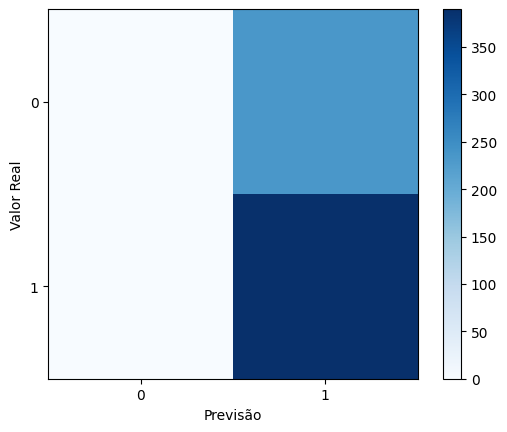

In [22]:
cm = confusion_matrix(y_test, y_pred)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel("Previsão")
plt.ylabel("Valor Real")
plt.xticks([0, 1])
plt.yticks([0, 1])
plt.show()

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



In [1]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical

# assuming you've got these 4 arrays from somewhere
# x_train, x_test, y_train, y_test
print('AHAHAHAHAHAHAAH')
# normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0

# convert labels to one-hot vectors
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('AHAHAHAHAHAHAAH')
# define the model structure
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
model = Sequential()
model.add(base_model)
model.add(Dense(y_train.shape[1], activation='softmax'))  # y_train.shape[1] is num_classes
print('BABABABABABABAABABAB')
# do not train the base model, only train the classifier layer
base_model.trainable = False

# compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5)

# after initial training, you may want to fine-tune the entire model with a lower learning rate
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5)


2023-06-11 16:20:53.954201: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-11 16:20:54.448806: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-11 16:20:54.453783: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 16:20:58.802310: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


AHAHAHAHAHAHAAH


NameError: name 'x_train' is not defined